In [1]:
## import dependencies

import pandas as pd
import matplotlib.pylab as plt


The previous time step(s) is useful in predicting the value at the next time step (dependance between values)
Your data is stationary. A time series is stationary if is mean (and/or variance) is constant over time. There are other statistical properties to look at as well, but looking at the mean is usually the fastest/easiest.

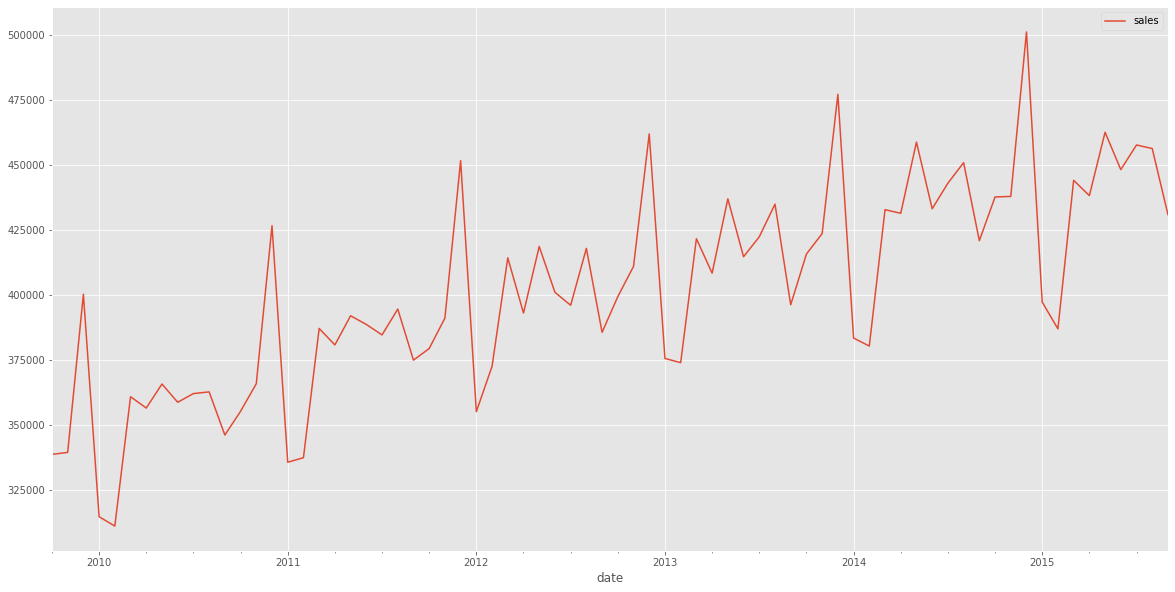

In [4]:
#set parameters for matplot lib such as size 
plt.rcParams['figure.figsize'] = (20, 10 )
plt.style.use('ggplot')
#load cas and convert colum to date time format

sales_data = pd.read_csv('retail_sales.csv')
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)

sales_data.plot()

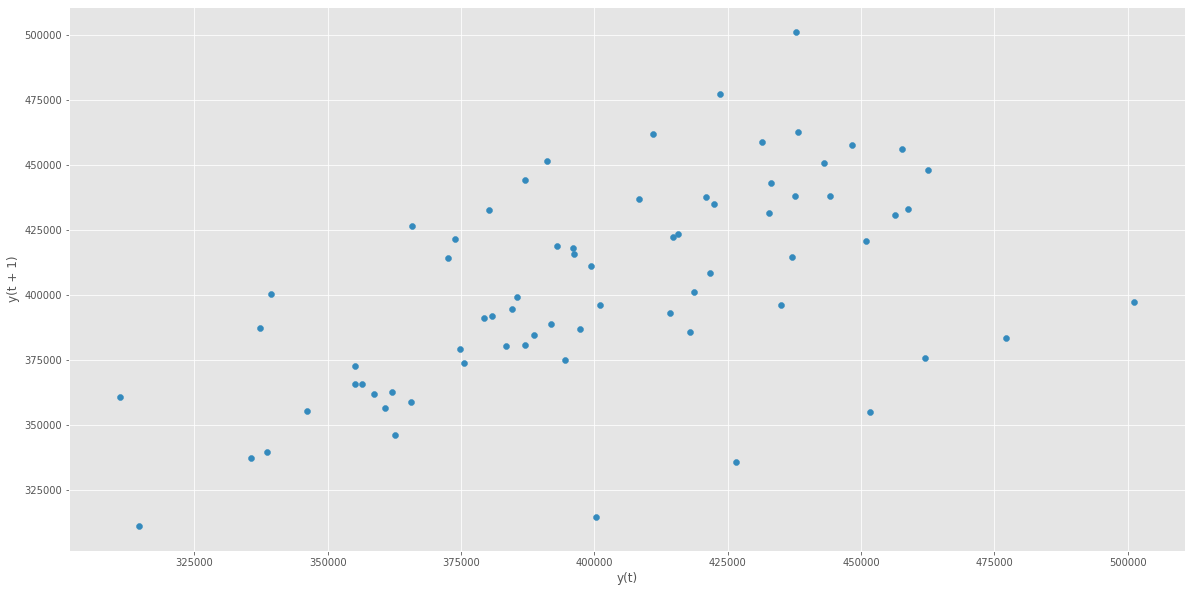

In [6]:
# we need to check for correlation- a good first step when using auto regression
pd.plotting.lag_plot(sales_data['sales'])
#if the data is highly correlated we should see a close grouping of datapoints that aling along a point/line on the plot
# we have some outliers in this data set


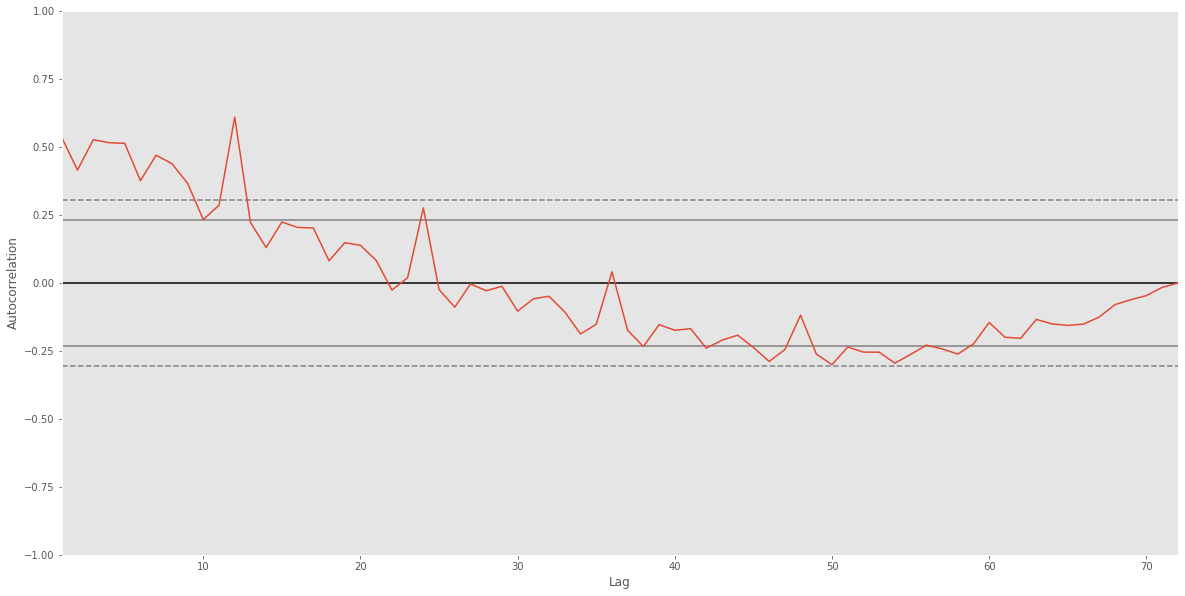

In [7]:
#you can use pandas to plot an auto correlation plot 
pd.plotting.autocorrelation_plot(sales_data['sales'])
#the light horizontal lines are the 95% convidence level and the dashed lines are the 99% confidence level
#appears we have some significant correlation between t=1 anmd t=12(lag). This appears to make sense with correlations falling off at the start of the new year


In [9]:
# we can check pearson correlation of the sales data with lagged values

sales_data['sales'].corr(sales_data['sales'].shift(12))
# we use 12 because this is appeared to have the highest correlation value above


0.9790985975895788

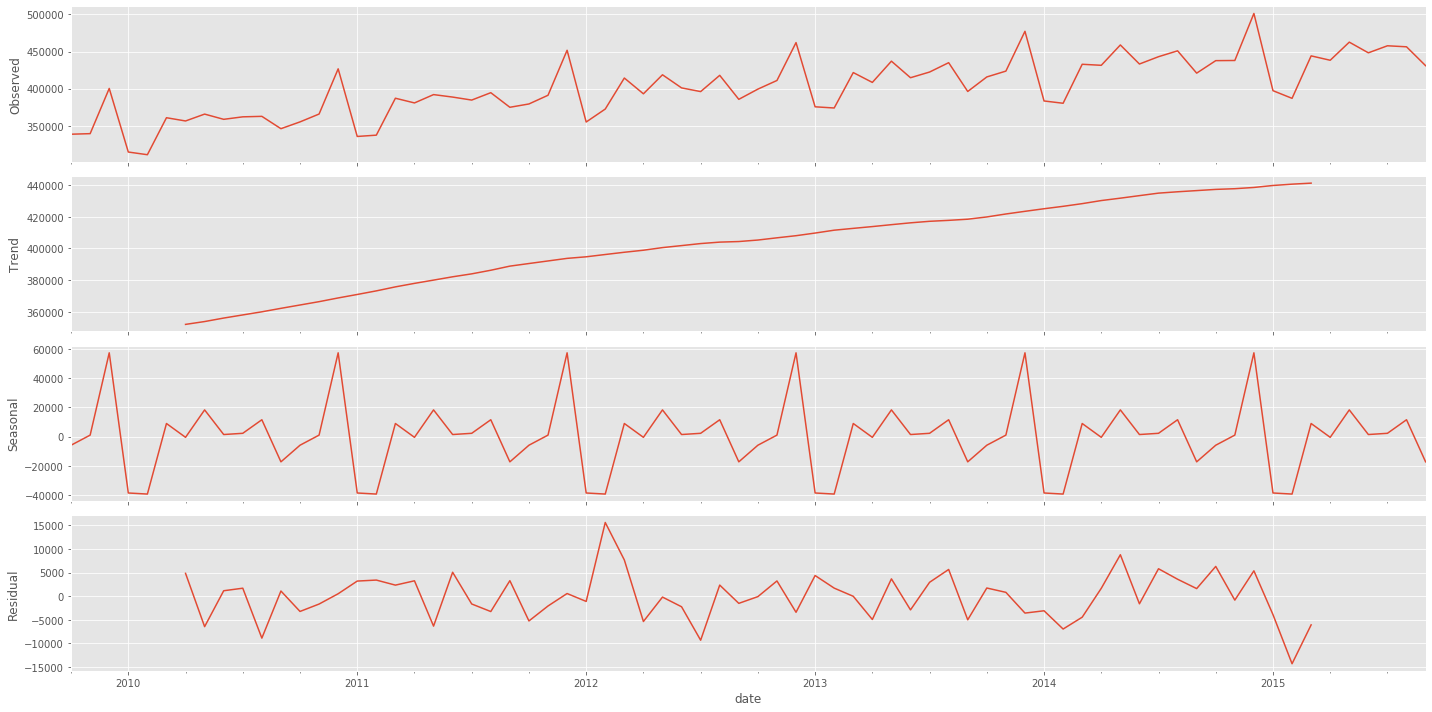

In [12]:
#using the charts above, we can infer we do not have a stationary data set, it appears to increase from 2010-2015 and is highly seasonal
# we can see seasonality using seasonal_decompose() in statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(sales_data['sales'], model='additive')
x = decomposed.plot()

## the trend line clearly shows a trend in the data
#third chart from top supports that the data has seasonality 

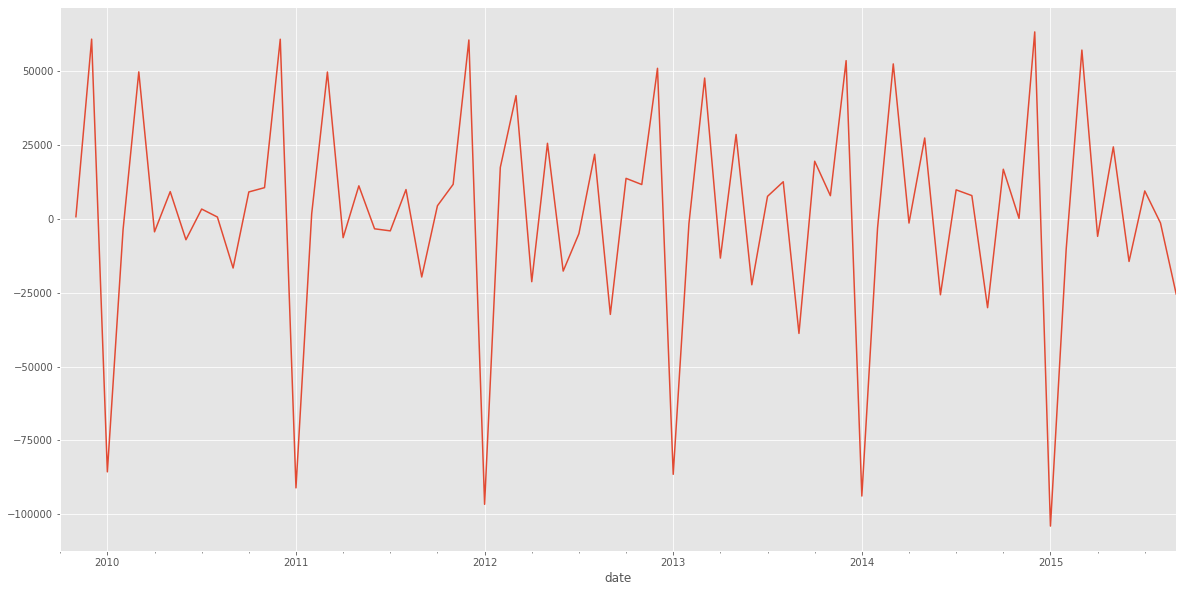

In [20]:
# we can use difference to get a more stationary model 
sales_data['stationary'] = sales_data['sales'].diff()
sales_data['stationary'].plot()

In [21]:
decomposed = seasonal_decompose(sales_data['stationary'], model='additive')
x = decomposed.plot()
#this will not run because the data set sales_data['stationary'] has nan values, we will address this next


ValueError: This function does not handle missing values

In [22]:
#this model auto selects the lag value for modeling 
from statsmodels.tsa.ar_model import AR

#create train/test datasets
X = sales_data['stationary'].dropna()
train_data = X[1:len(X)-12]
test_data = X[X[len(X)-12:]]

#train the autoregression  model
mode = AR(train_data)
model_fitted = mode.fit()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Lags are very useful in time series analysis because of a phenomenon called autocorrelation, which is a tendency for the values within a time series to be correlated with previous copies of itself. 


The lag operator (also known as backshift operator) is a function that shifts (offsets) a time series such that the “lagged” values are aligned with the actual time series. 

In [24]:
print('The lag value chosen is %s' % model_fitted.k_ar)

print('The coefficients of the model are:\n %s' % model_fitted.params)


#if you look at the autocorrelation plot, you can see a lab value of 10 when the line touches the 95% confidence level
#this is how you would usually select the lag value if you were selecting manually


The lag value chosen is 10
The coefficients of the model are:
 const             7720.952626
L1.stationary       -1.297636
L2.stationary       -1.574980
L3.stationary       -1.403045
L4.stationary       -1.123204
L5.stationary       -0.472200
L6.stationary       -0.014586
L7.stationary        0.564099
L8.stationary        0.792080
L9.stationary        0.843242
L10.stationary       0.395546
dtype: float64


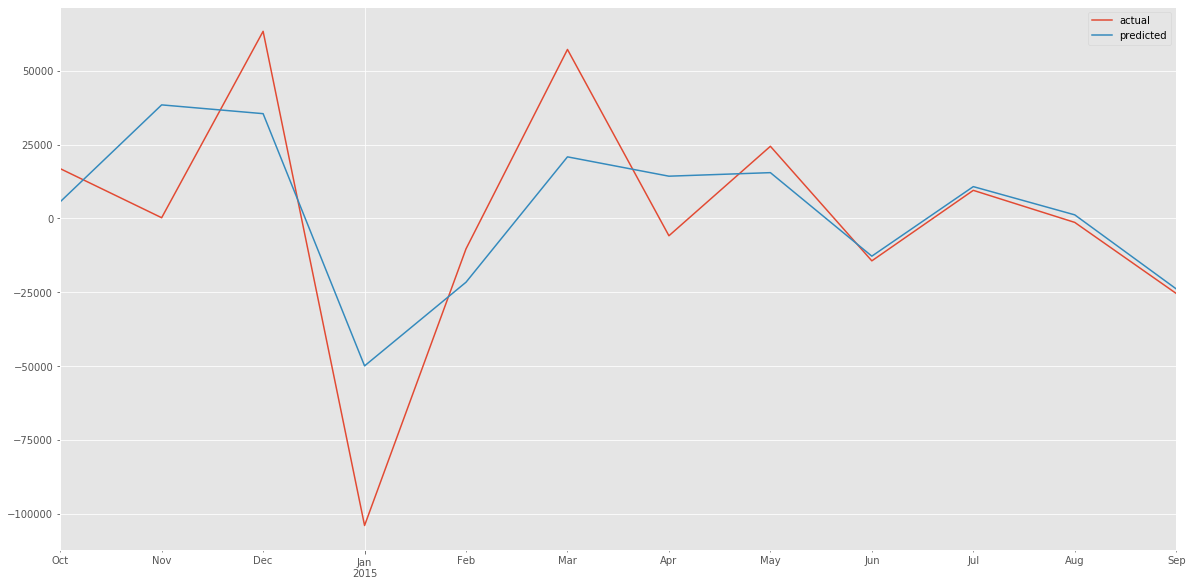

In [27]:
# lets make some predictions

predictions = model_fitted.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data)-1,
    dynamic=False)

#create a comparison dataframe
compare_df = pd.concat(
    [sales_data['stationary'].tail(12),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()


In [29]:
#the model caputes the general trend but does not capture the highs or lows

from sklearn.metrics import r2_score

r2 = r2_score(sales_data['stationary'].tail(12), predictions)
r2

0.6392721768478082

#r2 score
# is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).”So if it is 100%, the two variables are perfectly correlated, i.e., with no variance at all